In [ ]:
# importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import PIL
from PIL import Image
import random
import matplotlib.image as mpimg
import keras
import glob

%matplotlib inline

In [ ]:
# importing the libraries

from os import listdir
from os.path import join

In [ ]:
# importing the libraries

from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate , Input, Reshape, Dense, Flatten, GRU, Bidirectional, Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
import numpy as np

In [ ]:
# Loading and preprocessing the images using ResNet152V2 architecture

images = []
files = listdir('/content/drive/MyDrive/HTML/images/')
files.sort()
for filename in files:
    images.append(img_to_array(load_img('/content/drive/MyDrive/HTML/images/'+filename, target_size=(299, 299))))
images = np.array(images, dtype=float)
images = preprocess_input(images)

# Run the images through resnet152V2 
resnet = ResNet152V2(weights='imagenet', include_top=False)
features = resnet.predict(images)

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
# printing the shape of the extracted features
features.shape

(5, 10, 10, 2048)

In [ ]:
# This piece of code is referred from the website "https://www.programmersought.com/article/3918650197/"

maximum_caption_length = 100
token = Tokenizer(filters='', split=" ", lower=False)

# Function to read the document
def read_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Loading the HTML files
X = []
all_files = listdir('/content/drive/MyDrive/dataset_new1.3/html/')
all_files.sort()
for filename in all_files:
    X.append(read_file('/content/drive/MyDrive/dataset_new1.3/html/'+filename))

# Creating the vocabulary from html files
token.fit_on_texts(X)

# Add +1 to leave space for empty words
vocab_size = len(token.word_index) + 1

sequences = token.texts_to_sequences(X)
max_length = max(len(s) for s in sequences)

X, y, image_data = list(), list(), list()
for img_no, seq in enumerate(sequences):
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        # Padding the sentences, if the sentence is short
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        image_data.append(ext_features[img_no])
        X.append(in_seq[-100:])
        y.append(out_seq)

X, y, image_data = np.array(X), np.array(y), np.array(image_data)

In [ ]:
# Model building

from keras.regularizers import l2, l1

# Create the encoder
image = Input(shape=(9, 9, 1920,))
image_flatten = Flatten()(image)
image_flatten = Dense(128, activation='relu')(image_flatten)
rep_vec = RepeatVector(maximum_caption_length)(image_flatten)

language_input = Input(shape=(maximum_caption_length,))
language = Embedding(vocab_size, 200, input_length=maximum_caption_length)(language_input)
language = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences=True))(language)
language = Dropout(0.3)(language)
language = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences = True))(language)
language = Dropout(0.3)(language)
language = Bidirectional(LSTM(64, return_sequences=True))(language)
language = TimeDistributed(Dense(32, activation='relu'))(language)

# Create the decoder
decoder = concatenate([rep_vec, language])
decoder = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences=False))(decoder)
decoder_output = Dense(vocab_size, activation='softmax')(decoder)



In [ ]:
# Compile the model
import tensorflow 
from tensorflow.keras.optimizers import RMSprop


model = Model(inputs=[image, language_input], outputs=decoder_output)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(lr = 0.001, decay = 0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Train the neural network
history = model.fit([image_data, X], y, batch_size=64, shuffle=False, epochs=200, validation_split = 0.2)

Epoch 1/200
29/29 [==============================] - 27s 431ms/step - loss: 16.3412 - val_loss: 13.1573
Epoch 2/200
29/29 [==============================] - 8s 278ms/step - loss: 10.9045 - val_loss: 9.2650
Epoch 3/200
29/29 [==============================] - 8s 275ms/step - loss: 7.6780 - val_loss: 7.0957
Epoch 4/200
29/29 [==============================] - 8s 276ms/step - loss: 6.1077 - val_loss: 6.3595
Epoch 5/200
29/29 [==============================] - 8s 277ms/step - loss: 5.8003 - val_loss: 6.3860
Epoch 6/200
29/29 [==============================] - 8s 278ms/step - loss: 5.7308 - val_loss: 6.4046
Epoch 7/200
29/29 [==============================] - 8s 276ms/step - loss: 5.7040 - val_loss: 6.5048
Epoch 8/200
29/29 [==============================] - 8s 275ms/step - loss: 5.6611 - val_loss: 6.4854
Epoch 9/200
29/29 [==============================] - 8s 274ms/step - loss: 5.6509 - val_loss: 6.6088
Epoch 10/200
29/29 [==============================] - 8s 270ms/step - loss: 5.6454 - va

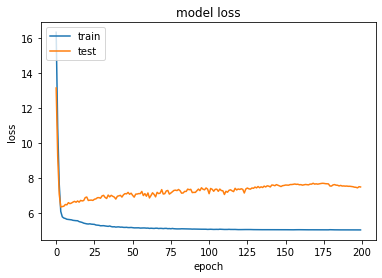

In [ ]:
# Visualizing the loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# This piece of code is referred from "https://www.programmersought.com/article/3918650197/"
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# This piece of code is referred from the website "https://www.programmersought.com/article/3918650197/"

# generate a description for an image
def description(model, tokenizer, photo, maximum_length):
    in_text = 'START'
    for i in range(900):
        seq = tokenizer.texts_to_sequences([in_text])[0][-100:]
        seq = pad_sequences([seq], maxlen=maximum_length)
        yhat = model.predict([photo,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        print(' ' + word, end='')
        if word == 'END':
            break
    return

In [ ]:
# Testing 
test = img_to_array(load_img('/content/drive/MyDrive/HTML/images/87.jpg', target_size=(299, 299)))
test = np.array(test, dtype=float)
test = preprocess_input(test)
test_features = densenet.predict(np.array([test]))
description(model, token, np.array(test_features), 100)

 <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><a <li><